# Gradient Domain Fusion - Noam Isachar

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

datadir = ""

import utils

## Part 1 Toy Problem (20 pts)

In [3]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. 
    Reconstruct this image from its gradient values, plus one pixel intensity. 
    Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). 
    For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    
    height, width = toy_img.shape 
    indices = np.arange(height * width).reshape(height, width) 
    
    num_equations = height*(width-1) + (height-1)*width + 1
    A = scipy.sparse.lil_matrix((num_equations, height*width))
    b = np.zeros(num_equations)

    equation_index = 0
    for y in range(height):
        for x in range(width-1):
            A[equation_index, indices[y, x+1]] = 1 
            A[equation_index, indices[y, x]] = -1 
            b[equation_index] = toy_img[y, x+1] - toy_img[y, x]
            equation_index += 1
    
    for y in range(height-1):
        for x in range(width):
            A[equation_index, indices[y+1, x]] = 1 
            A[equation_index, indices[y, x]] = -1 
            b[equation_index] = toy_img[y+1, x] - toy_img[y, x]
            equation_index += 1
            
    A[equation_index, indices[0, 0]] = 1 
    b[equation_index] = toy_img[0, 0]

    A = A.tocsr()
    v = scipy.sparse.linalg.lsqr(A, b, atol=1e-14, btol=1e-14)[0]
    
    return v.reshape((height, width))

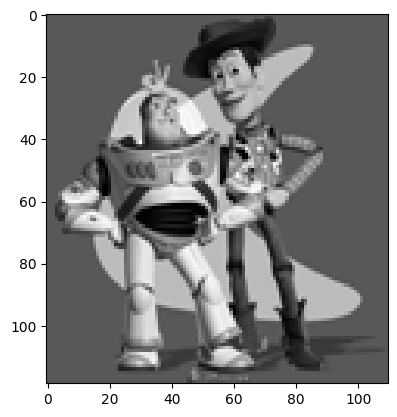

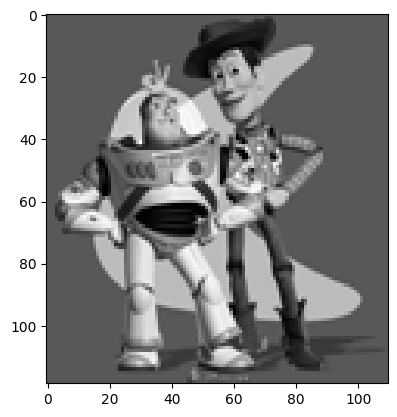

Max error is:  7.416678382554664e-12


In [4]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

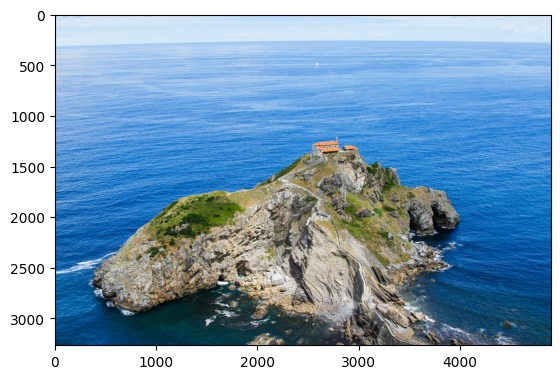

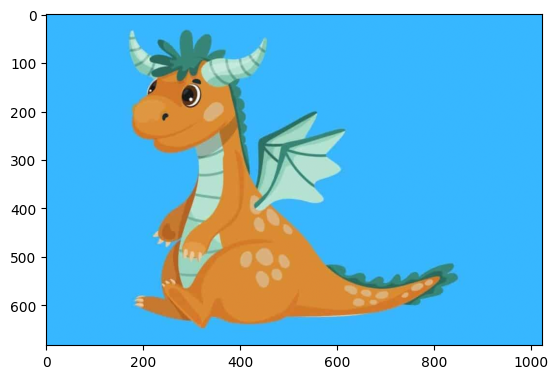

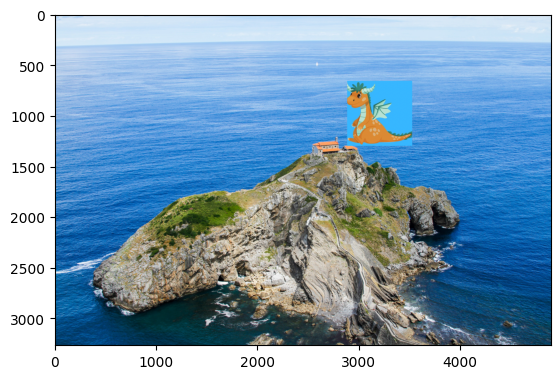

In [5]:
background_img = cv2.cvtColor(cv2.imread('samples/dragonstone.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/light_dragon.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
    xs = (180, 820, 820, 180)
    ys = (20, 20, 660, 660)
    object_mask = utils.get_mask(ys, xs, object_img)
    bottom_center = (3200, 1300) # (x,y)

    object_img, object_mask = utils.crop_object_img(object_img, object_mask)
    bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
    plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

In [6]:
if use_interface:
    import matplotlib.pyplot as plt
    %matplotlib notebook
    mask_coords = specify_mask(object_img)

In [7]:
if use_interface:
    xs = mask_coords[0]
    ys = mask_coords[1]
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure()
    object_mask = get_mask(ys, xs, object_img)

In [8]:
if use_interface:
    %matplotlib notebook
    import matplotlib.pyplot as plt
    bottom_center = specify_bottom_center(background_img)
    %matplotlib inline
    import matplotlib.pyplot as plt

    object_img, object_mask = utils.crop_object_img(object_img, object_mask)
    bg_ul = utils.upper__left_background_rc(object_mask, bottom_center)
    plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

## Part 2 Poisson Blending (50 pts)

In [9]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    This function performs Poisson blending to blend an object image onto a background image. 
    The blending process ensures that the resulting image is seamless and looks natural. 

    :param object_img: numpy.ndarray   the image of the object to be blended
    :param object_mask: numpy.ndarray  a binary mask indicating the region of the object to be blended
    :param bg_img: numpy.ndarray       the background image
    :param bg_ul: int tuple            the upper left coordinates of the region where the object is to be blended on the background image
    
    :return: numpy.ndarray             the blended image
    """
    height, width = object_img.shape
    im2var = np.arange(height * width).reshape(height, width)
    y_shift, x_shift = bg_ul
    
    b_top = np.array([[object_img[y][x]-object_img[y+1][x] if object_mask[y][x]==1 else bg_img[y+y_shift][x+x_shift] for x in range(width)] for y in range(height) if y!=height-1]).flatten()
    row_top = np.append(np.arange(height*width - width), np.arange(height*width - width))
    col_top = np.append(
        np.array([[im2var[y][x] if object_mask[y][x]==1 else im2var[y+1][x] for x in range(width)]for y in range(height) if y!=height-1]).flatten(), 
        np.array([[im2var[y+1][x] for x in range(width)] for y in range(height) if y!=height-1]).flatten()
    )
    data_top = np.append(
        np.ones(height*width - width), 
        np.array([[-1 if object_mask[y][x]==1 else 0 for x in range(width)] for y in range(height) if y!=height-1]).flatten()
    )
    
    b_bottom = np.array([[object_img[y][x]-object_img[y-1][x] if object_mask[y][x]==1 else bg_img[y+y_shift][x+x_shift] for x in range(width)]for y in range(height) if y!=0]).flatten()
    row_bottom = np.append(np.arange(height*width - width, 2*(height*width - width)), np.arange(height*width - width, 2*(height*width - width)))
    col_bottom = np.append(
        np.array([[im2var[y][x] if object_mask[y][x]==1 else im2var[y-1][x] for x in range(width)]for y in range(height) if y!=0]).flatten(), 
        np.array([[im2var[y-1][x] for x in range(width)]for y in range(height) if y!=0]).flatten()
    )
    data_bottom = np.append(
        np.ones(height*width - width) , 
        np.array([[-1 if object_mask[y][x]==1 else 0 for x in range(width)]for y in range(height) if y!=0]).flatten()
    )

    b_right = np.array([[object_img[y][x]-object_img[y][x+1] if object_mask[y][x]==1 else bg_img[y+y_shift][x+x_shift] for y in range(height)]for x in range(width) if x!=width-1]).flatten()
    row_right = np.append(np.arange(2*(height*width - width), 3*(height*width)-2*width - height), np.arange(2*(height*width - width), 3*(height*width)-2*width - height))
    col_right = np.append(
        np.array([[im2var[y][x] if object_mask[y][x]==1 else im2var[y][x+1] for y in range(height)]for x in range(width) if x!=width-1]).flatten(),
        np.array([[im2var[y][x+1] for y in range(height)]for x in range(width) if x!=width-1]).flatten()
    )
    data_right = np.append(
        np.ones(height*width - height),
        np.array([[-1 if object_mask[y][x]==1 else 0 for y in range(height)]for x in range(width) if x!=width-1]).flatten()
    )
    
    b_left = np.array([[object_img[y][x]-object_img[y][x-1] if object_mask[y][x]==1 else bg_img[y+y_shift][x+x_shift] for y in range(height)]for x in range(width) if x!=0]).flatten()
    row_left = np.append(np.arange(3*(height*width)-2*width - height, 4*(height*width)-2*width - 2*height), np.arange(3*(height*width)-2*width - height, 4*(height*width)-2*width - 2*height))
    col_left = np.append(
        np.array([[im2var[y][x] if object_mask[y][x]==1 else im2var[y][x-1] for y in range(height)]for x in range(width) if x!=0]).flatten(), 
        np.array([[im2var[y][x-1] for y in range(height)]for x in range(width) if x!=0]).flatten()
    )
    data_left = np.append(
        np.ones(height*width - height), 
        np.array([[-1 if object_mask[y][x]==1 else 0 for y in range(height)]for x in range(width) if x!=0]).flatten()
    )
    
    rows = np.concatenate((row_top, row_bottom, row_right, row_left))
    cols = np.concatenate((col_top, col_bottom, col_right, col_left))
    data = np.concatenate((data_top, data_bottom, data_right, data_left))
    
    A = scipy.sparse.coo_matrix((data, (rows, cols)), shape=(4*(height*width)-2*height-2*width, height*width))
    b = np.concatenate((b_top, b_bottom, b_right, b_left))
    b = np.array([b]).T
    
    blended_img, _, _, _ = scipy.sparse.linalg.lsqr(A, b)[:4]
    blended_img = blended_img.reshape(height, width)
    return blended_img

In [10]:
im_blend = np.zeros(object_img.shape)
for b in np.arange(3):
    im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


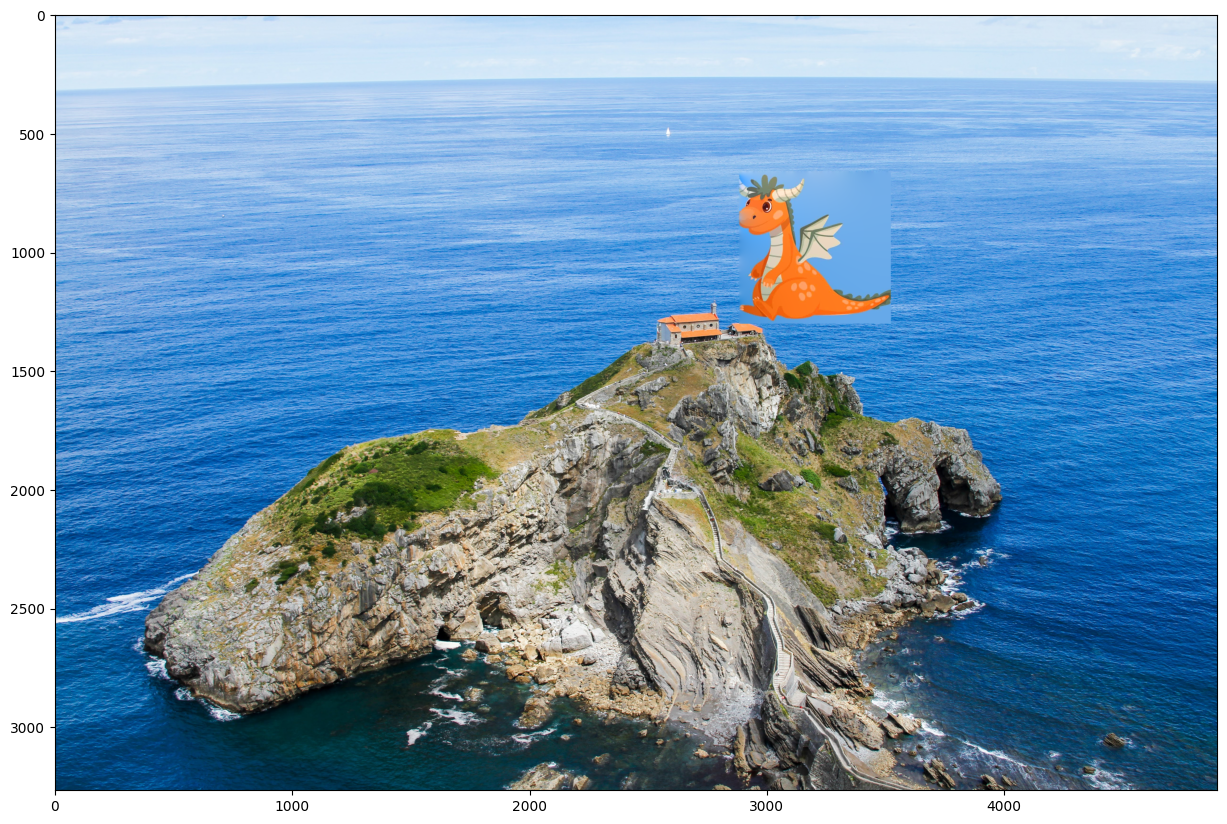

In [11]:
combined_img = utils.get_combined_img(background_img, im_blend, object_mask, bg_ul)
plt.figure(figsize=(15,15))
plt.imshow(combined_img)

## Part 3 Mixed Gradients (20 pts)

In [12]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    The function creates a matrix equation to solve for a seamless background replacement by maximizing the gradient between the object and background images 
    while preserving the object's boundary.

    :param object_img: numpy.ndarray   the image of the object to be blended
    :param object_mask: numpy.ndarray  a binary mask indicating the region of the object to be blended
    :param bg_img: numpy.ndarray       the background image
    :param bg_ul: int tuple            the upper left coordinates of the region where the object is to be blended on the background image
    
    :return: numpy.ndarray             the blended image
    """
    
    height, width = object_img.shape
    im2var = np.arange(height * width).reshape(height, width)
    y_shift, x_shift = bg_ul
    
    b_top = np.array([[max([object_img[y][x]-object_img[y+1][x], bg_img[y+y_shift][x+x_shift]-bg_img[y+y_shift+1][x+x_shift]], key=abs) if object_mask[y][x]==1 else bg_img[y+y_shift][x+x_shift] for x in range(width)] for y in range(height) if y!=height-1]).flatten()
    row_top = np.append(np.arange(height*width - width), np.arange(height*width - width))
    col_top = np.append(
        np.array([[im2var[y][x] if object_mask[y][x]==1 else im2var[y+1][x] for x in range(width)]for y in range(height) if y!=height-1]).flatten(),
        np.array([[im2var[y+1][x] for x in range(width)] for y in range(height) if y!=height-1]).flatten()
    )
    data_top = np.append(
        np.ones(height*width - width), 
        np.array([[-1 if object_mask[y][x]==1 else 0 for x in range(width)] for y in range(height) if y!=height-1]).flatten()
    )
    
    b_bottom = np.array([[max([object_img[y][x]-object_img[y-1][x], bg_img[y+y_shift][x+x_shift]-bg_img[y+y_shift-1][x+x_shift]], key=abs) if object_mask[y][x]==1 else bg_img[y+y_shift][x+x_shift] for x in range(width)]for y in range(height) if y!=0]).flatten()
    row_bottom = np.append(np.arange(height*width - width, 2*(height*width - width)), np.arange(height*width - width, 2*(height*width - width)))
    col_bottom = np.append(
        np.array([[im2var[y][x] if object_mask[y][x]==1 else im2var[y-1][x] for x in range(width)]for y in range(height) if y!=0]).flatten(), 
        np.array([[im2var[y-1][x] for x in range(width)]for y in range(height) if y!=0]).flatten()
    )
    data_bottom = np.append(
        np.ones(height*width - width), 
        np.array([[-1 if object_mask[y][x]==1 else 0 for x in range(width)]for y in range(height) if y!=0]).flatten()
    )
    
    b_right = np.array([[max([object_img[y][x]-object_img[y][x+1], bg_img[y+y_shift][x+x_shift]-bg_img[y+y_shift][x+x_shift+1]], key=abs) if object_mask[y][x]==1 else bg_img[y+y_shift][x+x_shift] for y in range(height)]for x in range(width) if x!=width-1]).flatten()
    row_right = np.append(np.arange(2*(height*width - width), 3*(height*width)-2*width - height), np.arange(2*(height*width - width), 3*(height*width)-2*width - height))
    col_right = np.append(
        np.array([[im2var[y][x] if object_mask[y][x]==1 else im2var[y][x+1] for y in range(height)]for x in range(width) if x!=width-1]).flatten(), 
        np.array([[im2var[y][x+1] for y in range(height)]for x in range(width) if x!=width-1]).flatten()
    )
    data_right = np.append(
        np.ones(height*width - height), 
        np.array([[-1 if object_mask[y][x]==1 else 0 for y in range(height)]for x in range(width) if x!=width-1]).flatten()
    )
    
    b_left = np.array([[max([object_img[y][x]-object_img[y][x-1], bg_img[y+y_shift][x+x_shift]-bg_img[y+y_shift][x+x_shift-1]], key=abs) if object_mask[y][x]==1 else bg_img[y+y_shift][x+x_shift] for y in range(height)]for x in range(width) if x!=0]).flatten()
    row_left = np.append(np.arange(3*(height*width)-2*width - height, 4*(height*width)-2*width - 2*height), np.arange(3*(height*width)-2*width - height, 4*(height*width)-2*width - 2*height))
    col_left = np.append(
        np.array([[im2var[y][x] if object_mask[y][x]==1 else im2var[y][x-1] for y in range(height)]for x in range(width) if x!=0]).flatten(), 
        np.array([[im2var[y][x-1] for y in range(height)]for x in range(width) if x!=0]).flatten()
    )
    data_left = np.append(
        np.ones(height*width - height), 
        np.array([[-1 if object_mask[y][x]==1 else 0 for y in range(height)]for x in range(width) if x!=0]).flatten()
    )
    
    rows = np.concatenate((row_top, row_bottom, row_right, row_left))
    cols = np.concatenate((col_top, col_bottom, col_right, col_left))
    data = np.concatenate((data_top, data_bottom, data_right, data_left))
    
    A = scipy.sparse.coo_matrix((data, (rows, cols)), shape=(4*(height*width)-2*height-2*width, height*width))
    b = np.concatenate((b_top, b_bottom, b_right, b_left))
    b = np.array([b]).T
    
    blended_img, _, _, _ = scipy.sparse.linalg.lsqr(A, b)[:4]
    blended_img = blended_img.reshape(height, width)
    return blended_img

In [13]:
im_blend = np.zeros(object_img.shape)
for b in np.arange(3):
    im_blend[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


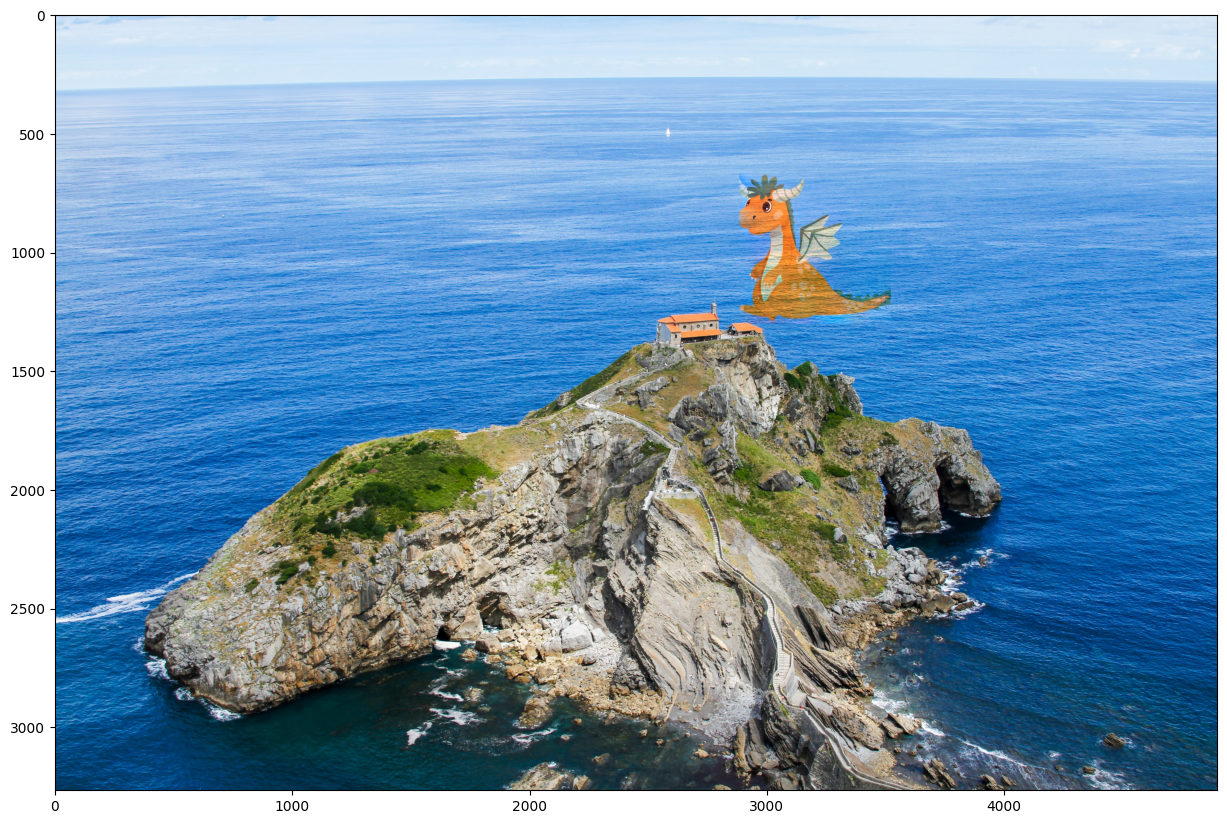

In [14]:
combined_img = utils.get_combined_img(background_img, im_blend, object_mask, bg_ul)
plt.figure(figsize=(15,15))
plt.imshow(combined_img)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [15]:
from skimage.color import rgb2gray

def color2gray(img):
    """
    This function converts an image to grayscale while preserving the gradients and the details in the photo.
    """
    gray = rgb2gray(img)
    
    gx, gy, gz = np.gradient(img)
    gradient_r = np.sqrt(gx[:,:,0]**2 + gy[:,:,0]**2 + gz[:,:,0]**2)
    gradient_g = np.sqrt(gx[:,:,1]**2 + gy[:,:,1]**2 + gz[:,:,1]**2)
    gradient_b = np.sqrt(gx[:,:,2]**2 + gy[:,:,2]**2 + gz[:,:,2]**2)

    gx_gray, gy_gray = np.gradient(gray)
    gradient_gray = np.sqrt(gx_gray**2 + gy_gray**2)
    avg_gradient_gray = np.mean(gradient_gray**2)
    avg_gradient_color = np.mean((gradient_r**2 + gradient_g**2 + gradient_b**2) / 3)

    alpha = avg_gradient_color / (avg_gradient_gray + 1e-8)
    gray_weighted = alpha * gray
    color_weighted = (1 - alpha) * np.mean(img,axis=2)
    combined = np.clip(gray_weighted + color_weighted, 0, 1)

    return combined

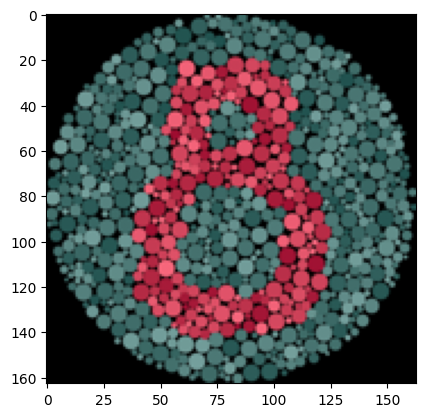

In [23]:
colored_img = cv2.cvtColor(cv2.imread('samples/colorBlind8.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(colored_img)

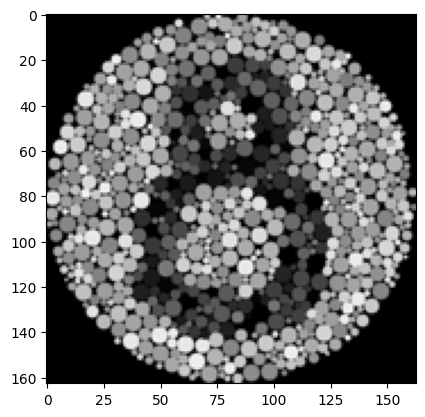

In [24]:
grey_img = color2gray(colored_img)
plt.figure()
plt.imshow(grey_img, cmap="gray")

## Laplacian pyramid blending (20 pts)

In [18]:
# def gaussian_pyramid(img, num_levels):
#     working_img = np.float32(img.copy())
#     gaussian_pyr = [working_img]
#     for i in range(num_levels):
#         working_img = cv2.pyrDown(working_img)
#         gaussian_pyr.append(np.float32(working_img))
#     return gaussian_pyr

# def laplacian_pyramid(gaussian_pyr):
#     laplacian_top = gaussian_pyr[-1]
#     num_levels = len(gaussian_pyr) - 1
    
#     laplacian_pyr = [laplacian_top]
#     for i in range(num_levels,0,-1):
#         size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])
#         gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
#         laplacian = np.subtract(gaussian_pyr[i-1], gaussian_expanded)
#         laplacian_pyr.append(laplacian)
#     return laplacian_pyr

# def blend(laplacian_A,laplacian_B,mask_pyr):
#     LS = []
#     for la,lb,mask in zip(laplacian_A,laplacian_B,mask_pyr):
#         ls = lb * mask + la * (1.0 - mask)
#         LS.append(ls)
#     return LS

# def reconstruct(laplacian_pyr):
#     laplacian_top = laplacian_pyr[0]
#     laplacian_lst = [laplacian_top]
#     num_levels = len(laplacian_pyr) - 1
#     for i in range(num_levels):
#         size = (laplacian_pyr[i + 1].shape[1], laplacian_pyr[i + 1].shape[0])
#         laplacian_expanded = cv2.pyrUp(laplacian_top, dstsize=size)
#         laplacian_top = cv2.add(laplacian_pyr[i+1], laplacian_expanded)
#         laplacian_lst.append(laplacian_top)
#     return laplacian_lst

In [19]:
# def laplacian_blend(background_img, mask, object_img, num_levels=6):
#     # calculate Gaussian and Laplacian
#     gaussian_pyr_1 = gaussian_pyramid(object_img, num_levels)
#     laplacian_pyr_1 = laplacian_pyramid(gaussian_pyr_1)
#     gaussian_pyr_2 = gaussian_pyramid(background_img, num_levels)
#     laplacian_pyr_2 = laplacian_pyramid(gaussian_pyr_2)

#     # calculate the Gaussian pyramid for the mask and reverse it
#     mask_pyr_final = gaussian_pyramid(mask, num_levels)
#     mask_pyr_final.reverse()

#     # blend the images
#     add_laplace = blend(laplacian_pyr_1,laplacian_pyr_2,mask_pyr_final)
#     # reconstruct the images
#     final = reconstruct(add_laplace)
#     # Save the final image to the disk
#     return final[num_levels]

In [20]:
# mask = np.zeros_like(background_img)
# mask[346:445,294:348,:] = (1,1,1)
# laplacian_img = laplacian_blend(utils.get_combined_img(background_img, object_img, object_mask, bg_ul), mask, background_img)
# plt.imshow(laplacian_img)